In [3]:
import pandas as pd
import glob

In [4]:
file_paths = glob.glob('data/프로젝트 데이터_API/상해_*.csv')  # 폴더 내 모든 CSV 파일 경로를 불러옵니다.

# 2. 여러 파일 불러와서 하나의 데이터프레임으로 좌우로 합치기
df_list = [pd.read_csv(file) for file in file_paths]

# 3. 데이터프레임 좌우 병합
df = pd.concat(df_list, axis=1)

# 4. 데이터 확인
print(df.head())  # 데이터의 처음 5행을 확인합니다.

# 5. 빈도수 분석 (좌우 병합의 경우 분석할 열을 정확히 지정해야 함)
column_names = {
    '사건명': 'Case_Name',
    '법원명': 'Court_Name',
    '사건종류명': 'Case_Type',
    '선고': 'Verdict',
    '판결유형': 'Judge_Type',
    '판시사항': 'Issue',
    '판결요지': 'Summary',
    '참조조문': 'Refer_Article',
    '참조판례': 'Refer_Precedent',
    '판례내용': 'Content'
}
frequency_results = {}

for column in column_names.keys():
    print(f"\n컬럼명: {column}")
    frequency_counts = df[column].value_counts(dropna=False)  # NaN 값 포함하여 빈도수 계산
    print(frequency_counts)
    
    # 영어 열 이름에 빈도수를 저장
    english_column_name = column_names[column]
    frequency_results[english_column_name] = frequency_counts

# 빈도수 결과 확인
for key, value in frequency_results.items():
    print(f"\n{key}의 빈도수:\n{value}")

   판례일련번호                                                사건명        사건번호  \
0  240925  폭행·특수상해(인정된죄명:상해)·특수협박(인정된죄명:협박)·감금[피고인이 위험한 물...  2023도18812   
1  240809  상해[형사소송법 제33조 제1항 제1호가 정한 필요적 국선변호인 선정사유인 ‘구속’...   2021도6357   
2  239933                                     상해(인정된죄명:강간상해)  2023도11371   
3  241179                                    강도상해·감금·폭행·강요미수  2023도12851   
4  240893       살인·상해·마약류관리에관한법률위반(마약)·마약류관리에관한법률위반(향정)·부착명령  2023도11559   

         선고일자  법원명 사건종류명                                             판례상세링크  \
0  2024.06.13  대법원    형사  /DRF/lawService.do?OC=younwjdtjr&target=prec&I...   
1  2024.05.23  대법원    형사  /DRF/lawService.do?OC=younwjdtjr&target=prec&I...   
2  2024.03.12  대법원    형사  /DRF/lawService.do?OC=younwjdtjr&target=prec&I...   
3  2024.02.08  대법원    형사  /DRF/lawService.do?OC=younwjdtjr&target=prec&I...   
4  2023.11.16  대법원    형사  /DRF/lawService.do?OC=younwjdtjr&target=prec&I...   

   판례정보일련번호                   사건번호  선고      판결유형  \
0    240925     

In [3]:
frequency_results.keys()

dict_keys(['Case_Name', 'Court_Name', 'Case_Type', 'Verdict', 'Judge_Type', 'Issue', 'Summary', 'Refer_Article', 'Refer_Precedent', 'Content'])

In [4]:
frequency_results['Issue']

판시사항
NaN                                                                                                                                                                                                                                                                                                                                                                                                                                        228
 유죄로 인정하기 위한 증거의 증명력 정도<br/>                                                                                                                                                                                                                                                                                                                                                                                                                 2
범행당시 심신미약의 상태에 있었다고 인정되는 사례<br/>                                                                                                     

In [6]:
issue=df['판시사항'].to_list()
issue[0]
mod_issue = [f"[CLS] {sentence} [SEP]" for sentence in issue]

print(mod_issue[0])

[CLS]   특수상해죄 및 특수협박죄의 구성요건 중 위험한 물건을 ‘휴대하여’의 의미 / 이때 범행 현장에서 위험한 물건을 사용하려는 의도가 있었는지 판단하는 기준 및 위험한 물건을 실제로 범행에 사용하였을 것까지 요구되는지 여부(소극) / 위험한 물건을 휴대하였다고 하기 위하여, 그 물건을 현실적으로 손에 쥐고 있는 등 피고인과 그 물건이 반드시 물리적으로 부착되어 있어야 하는지 여부(소극)<br/> [SEP]


# 판시사항을 KoBERT를 통해 텐서 뽑아내려 했으나 컴퓨팅 성능이 딸려서 렉걸려서 못하겠다.

In [7]:
from transformers import BertModel, DistilBertModel
bert_model = BertModel.from_pretrained('monologg/kobert')
distilbert_model = DistilBertModel.from_pretrained('monologg/distilkobert')

In [21]:
import sys
import os

# 현재 스크립트 경로
current_dir = os.path.dirname(os.path.abspath('eda_dh.ipynb'))

# kobert_transformers 경로 추가
kobert_transformers_path = os.path.join(current_dir, 'KoBERT-Transformers-master', 'kobert_transformers')
sys.path.append(kobert_transformers_path)
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

In [29]:
from kobert_transformers.utils import get_tokenizer
import torch

# Define your model
model = distilbert_model  # 모델 선언
tokenizer = get_tokenizer()  # 토크나이저 선언

sentences = mod_issue
#sentences에 해당하는 문장 리스트는 우리가 csv에서 뽑아올 리스트 이건 샘플
#각 문장은 앞에 [CLS], 뒤에 [SEP]이 꼭 있어야한다.(이것도 전처리하면서 넣어볼것)
inputs = tokenizer.encode(sentences, max_length=1375, truncation=True, padding='max_length', return_tensors='pt')
# 각 문장을 토큰화, id화
tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in sentences]
tokenid_list = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_sentences]

# sequence를 같은 길이로 padding
max_length = max(len(ids) for ids in tokenid_list)
padded_tokenid_list = [ids + [0] * (max_length - len(ids)) for ids in tokenid_list]

# Longtensor로 dtype변경
tokenid_tensor = torch.LongTensor(padded_tokenid_list)

# Print the tensor
print(tokenid_tensor)

# 추론
tensor_output = model(tokenid_tensor)  # 모델에 위의 전처리 과정을 거친 자연어를 input으로 넣는다
print(tensor_output[0].shape)  # Output shape
print(tensor_output[0])  # Output 확인

# 출력은 (batchsize, 토큰id의 길이, 768). 여기서 768은 임베딩 공간의 크기

tensor([[   2, 4783, 6527,  ...,    0,    0,    0],
        [   2, 5082, 6612,  ...,    0,    0,    0],
        [   2,  702,   93,  ...,    0,    0,    0],
        ...,
        [   2,  517, 5330,  ...,    0,    0,    0],
        [   2, 1023, 6607,  ...,    0,    0,    0],
        [   2, 1725, 7342,  ...,    0,    0,    0]])


RuntimeError: The size of tensor a (783) must match the size of tensor b (512) at non-singleton dimension 1

In [ ]:
from kobert_transformers.utils import get_tokenizer
import torch

# Define your model
model = distilbert_model  # 모델 선언
tokenizer = get_tokenizer()  # 토크나이저 선언

sentences = mod_issue  # 문장 리스트
# 각 문장을 토큰화, id화 (최대 길이를 512로 조정)
inputs = tokenizer(sentences, max_length=512, truncation=True, padding='max_length', return_tensors='pt')

# input_ids와 attention_mask 추출
tokenid_tensor = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Print the tensor
print(tokenid_tensor)

# 추론
tensor_output = model(input_ids=tokenid_tensor, attention_mask=attention_mask)  # 모델에 위의 전처리 과정을 거친 자연어를 input으로 넣는다
print(tensor_output[0].shape)  # Output shape
print(tensor_output[0])  # Output 확인

# 출력은 (batchsize, 토큰id의 길이, 768). 여기서 768은 임베딩 공간의 크기

tensor([[   2,    2, 4783,  ...,    1,    1,    1],
        [   2,    2, 5082,  ...,    1,    1,    1],
        [   2,    2,  702,  ...,    1,    1,    1],
        ...,
        [   2,    2,  517,  ...,    1,    1,    1],
        [   2,    2, 1023,  ...,    1,    1,    1],
        [   2,    2, 1725,  ...,    1,    1,    1]])


# 
ㄴ

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
from collections import Counter

# 한글 깨짐 방지
plt.rcParams['font.family'] = "Malgun Gothic"

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   판례일련번호    1015 non-null   int64 
 1   사건명       1015 non-null   object
 2   사건번호      1015 non-null   object
 3   선고일자      1015 non-null   object
 4   법원명       1015 non-null   object
 5   사건종류명     1015 non-null   object
 6   판례상세링크    1015 non-null   object
 7   판례정보일련번호  1015 non-null   int64 
 8   사건번호      1015 non-null   object
 9   선고        1015 non-null   object
 10  판결유형      1015 non-null   object
 11  판시사항      787 non-null    object
 12  판결요지      649 non-null    object
 13  참조조문      781 non-null    object
 14  참조판례      460 non-null    object
 15  판례내용      1015 non-null   object
dtypes: int64(2), object(14)
memory usage: 127.0+ KB


# 사건명

In [6]:
df['사건명'].value_counts()

사건명
강도상해                                                           57
상해                                                             47
강도상해피고사건                                                       33
상해치사                                                           25
폭력행위등처벌에관한법률위반(집단·흉기등상해)                                       16
                                                               ..
공무집행방해·상해·업무방해·집회 및 시위에 관한 법률 위반·업무방해방조                         1
공무집행방해·상해·업무방해·일반교통방해                                           1
강간상해·청소년의성보호에관한법률위반(청소년강간등)·마약류관리에관한법률위반(향정)                    1
폭력행위등처벌에관한법률위반(집단.흉기등상해)·폭력행위등처벌에관한법률위반(집단.흉기등협박)·업무방해·치료감호     1
독직상해                                                            1
Name: count, Length: 691, dtype: int64

In [14]:
df['사건명'].value_counts().values

array([57, 47, 33, 25, 16,  9,  9,  7,  6,  4,  4,  4,  4,  4,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [16]:
# 시각화 설정
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='사건명', data=df, palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('사건명 빈도수')
plt.xlabel('빈도수')
plt.ylabel('사건명')

# 그래프 표시
plt.show()

ValueError: Could not interpret value `count` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

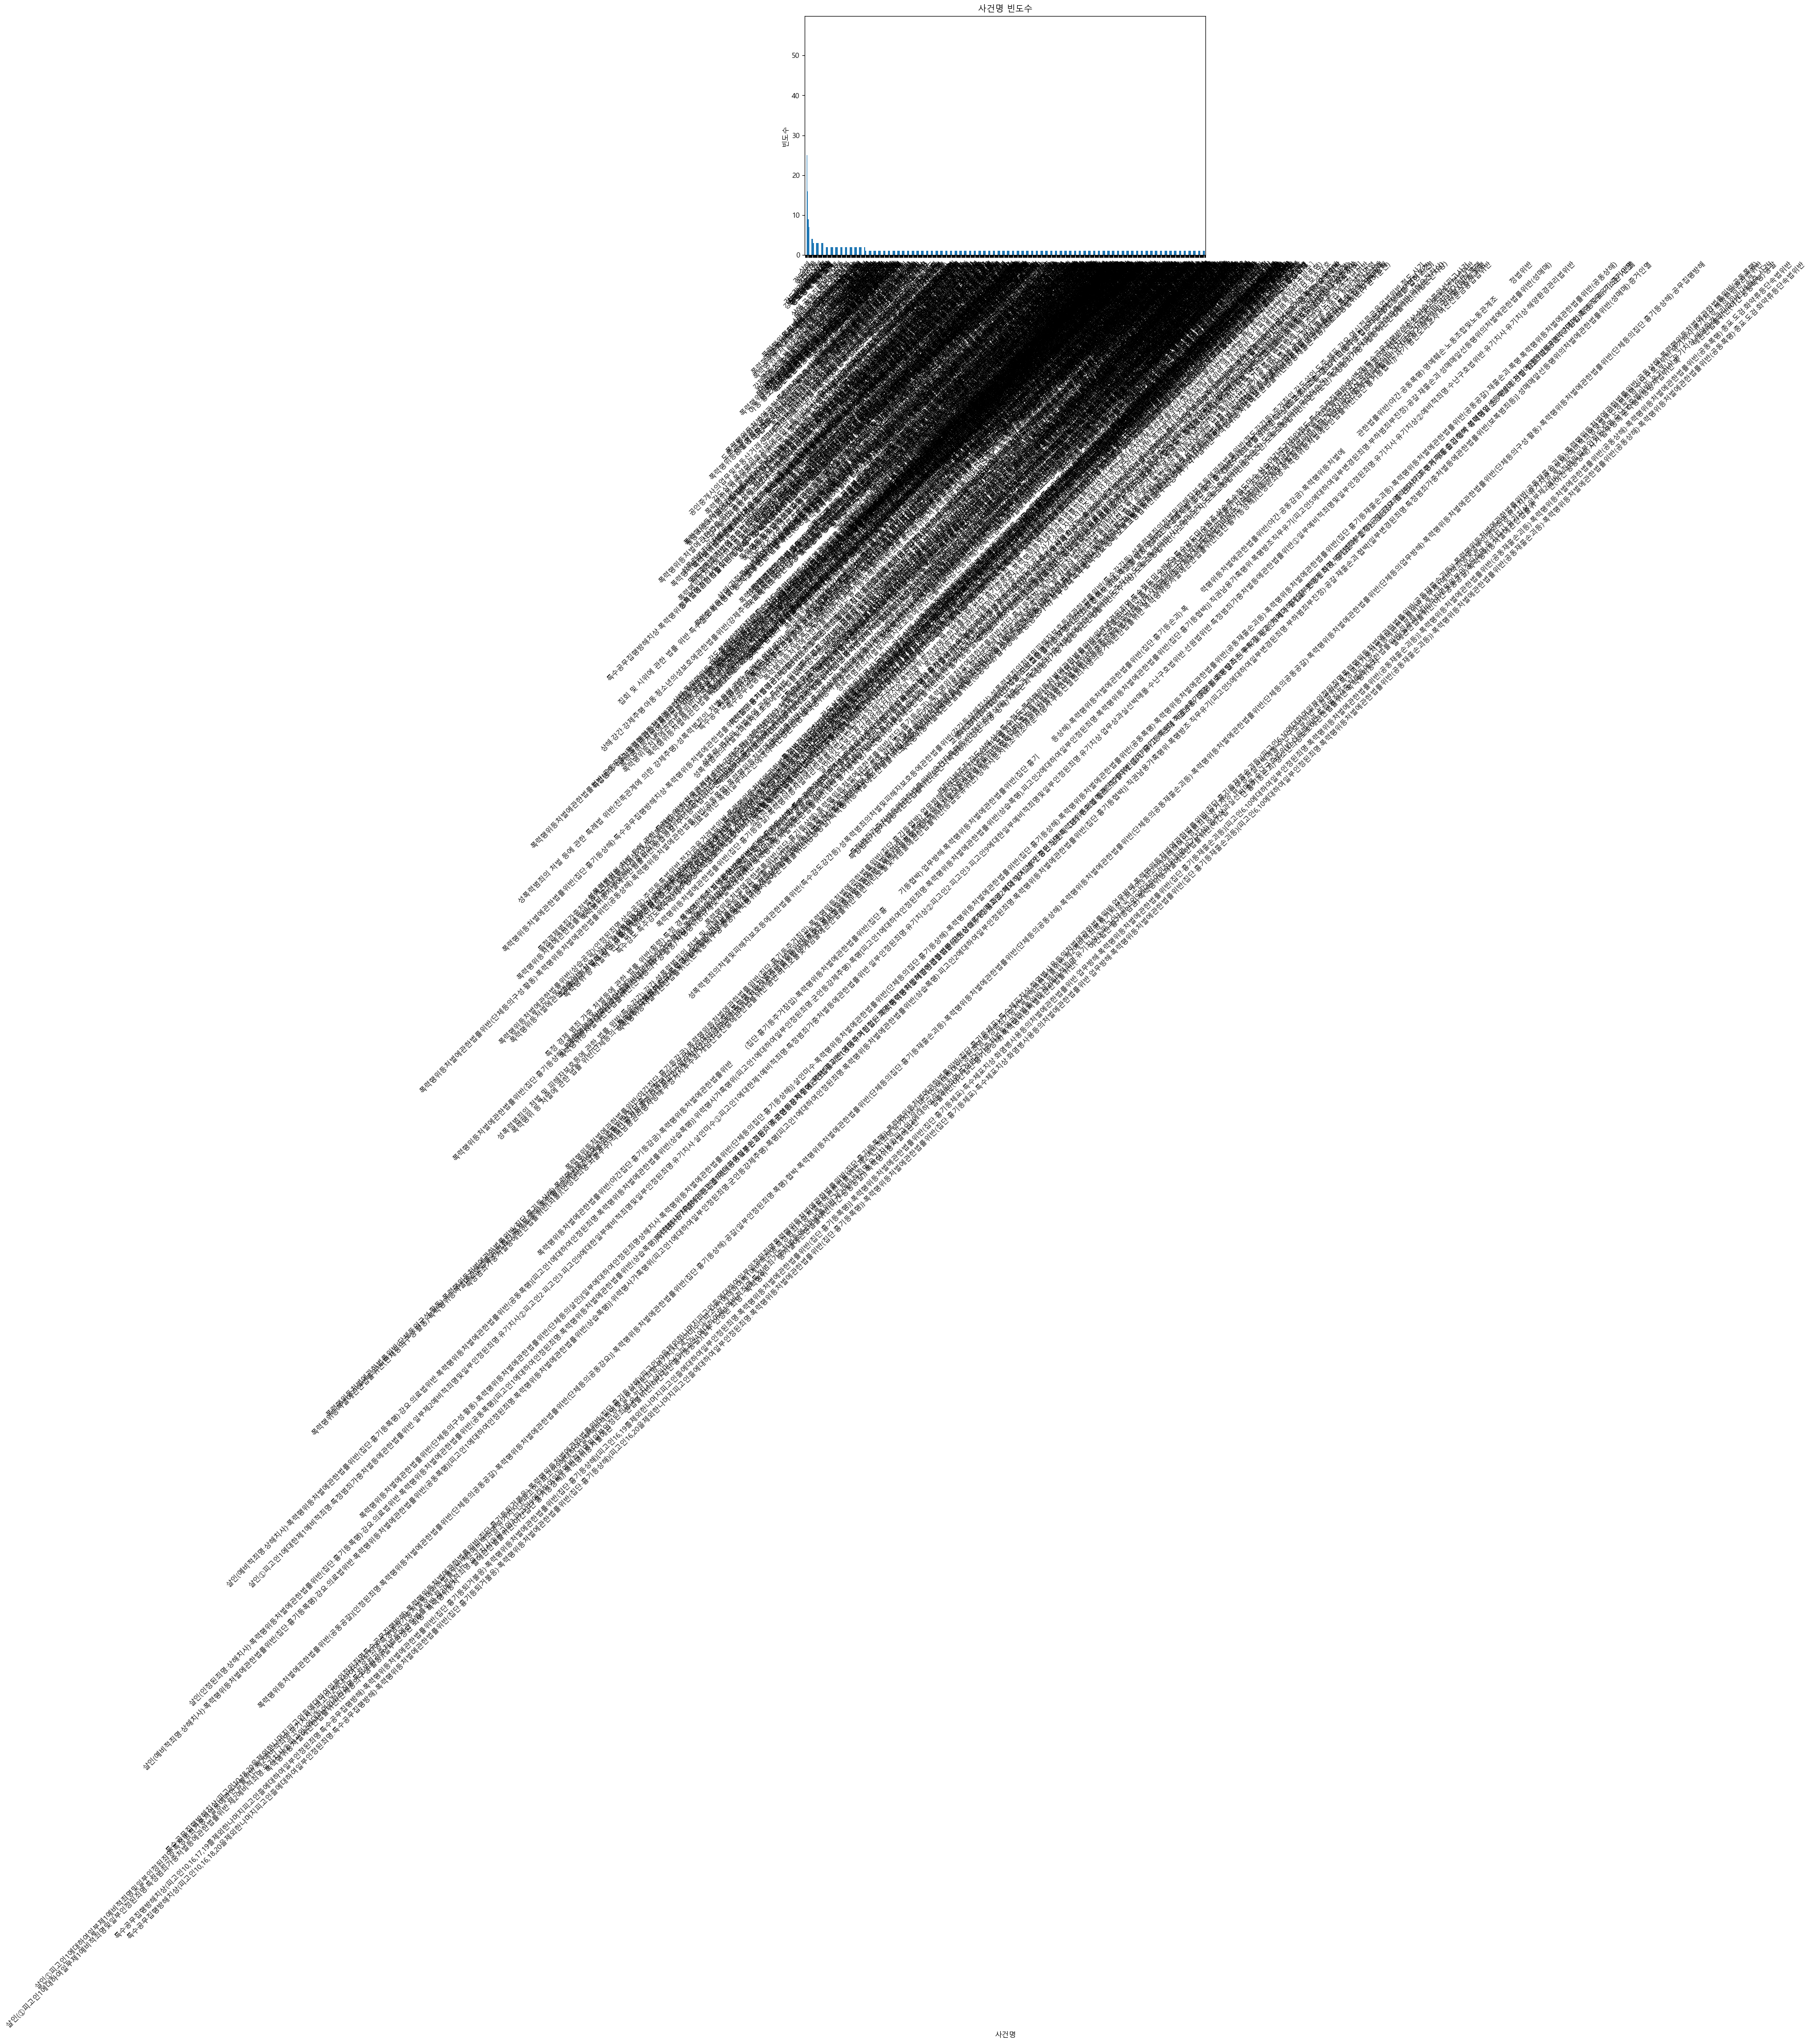

In [11]:
plt.figure(figsize=(10, 6))
df['사건명'].value_counts().plot(kind='bar')
plt.title('사건명 빈도수')
plt.xlabel('사건명')
plt.ylabel('빈도수')
plt.xticks(rotation=45)
plt.show()

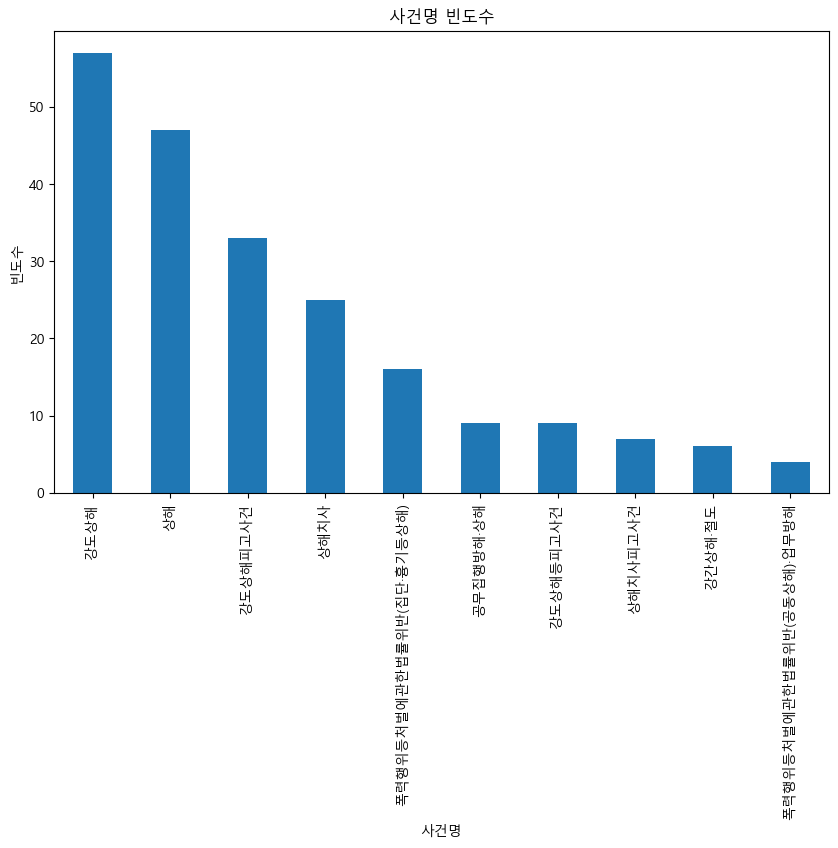

In [18]:
plt.figure(figsize=(10, 6))
df['사건명'].value_counts().head(10).plot(kind='bar')
plt.title('사건명 빈도수')
plt.xlabel('사건명')
plt.ylabel('빈도수')
plt.xticks(rotation=90)
plt.show()

In [24]:
filtered_df1=df['사건명'].value_counts()[df['사건명'].value_counts()>=5]

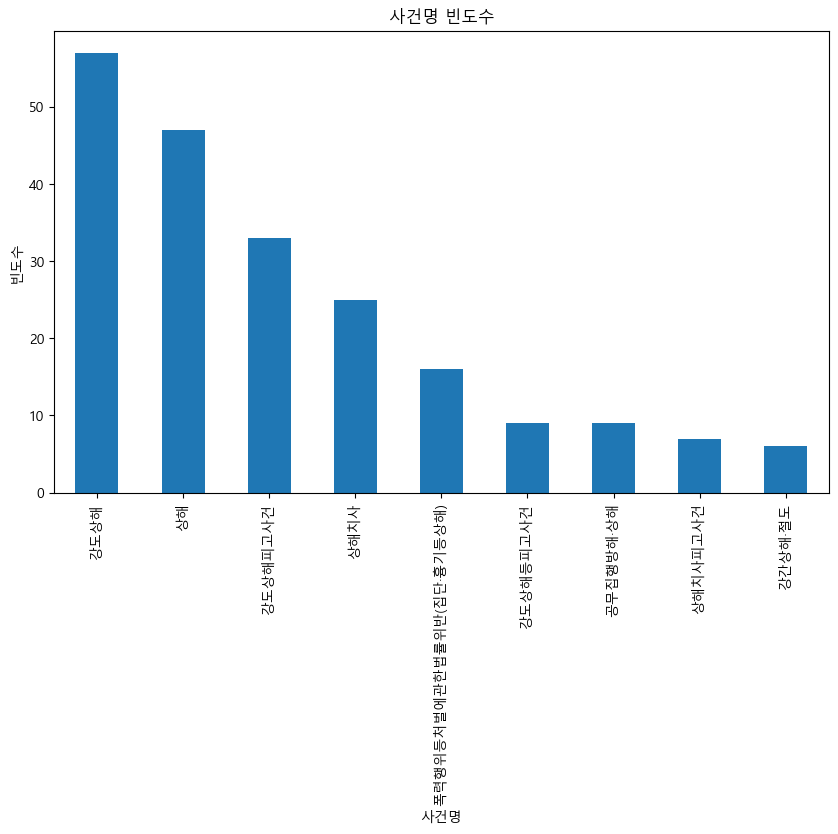

In [26]:
plt.figure(figsize=(10, 6))
filtered_df1.plot(kind='bar')
plt.title('사건명 빈도수')
plt.xlabel('사건명')
plt.ylabel('빈도수')
plt.xticks(rotation=90)
plt.show()

# 법원명

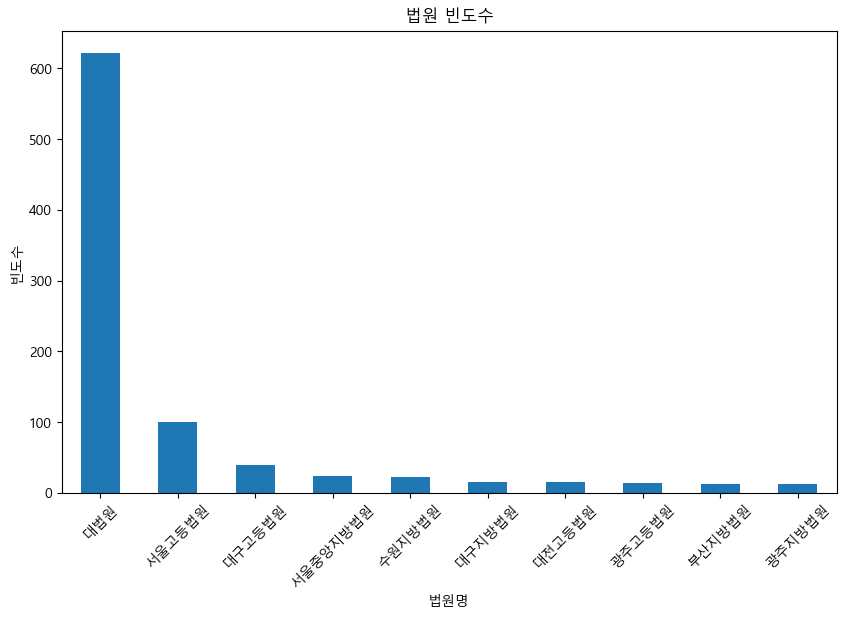

In [34]:
plt.figure(figsize=(10, 6))
df['법원명'].value_counts()[df['법원명'].value_counts()>10].plot(kind='bar')
plt.title('법원 빈도수')
plt.xlabel('법원명')
plt.ylabel('빈도수')
plt.xticks(rotation=45)
plt.show()

In [25]:
# 새로운 열을 추가하여 카테고리화, 기타의 경우 원래 이름 유지
df['법원_카테고리'] = df['법원명'].apply(
    lambda x: '지방법원' if '지방법원' in x else 
              '고등법원' if '고등법원' in x else 
              '대법원' if '대법원' in x else 
              '군사법원' if '군사법원' in x else x)
# 결과 확인
print(df['법원_카테고리'].value_counts())

법원_카테고리
대법원     622
지방법원    207
고등법원    179
군사법원      7
Name: count, dtype: int64


In [27]:
import re
# 카테고리 앞의 단어 추출
def extract_prefix(court_name):
    match = re.match(r'(.+?)(지방법원|고등법원|대법원|군사법원)', court_name)
    if match:
        return match.group(1)  # 앞에 있는 단어 반환
    return court_name  # 기타의 경우 원래 이름 반환

df['법원_지역'] = df['법원명'].apply(extract_prefix)

# 결과 확인
df['법원_지역'].value_counts()

법원_지역
대법원          622
서울           100
대구            59
광주            32
수원            31
대전            25
부산            24
서울중앙          24
춘천            12
창원             9
서울서부           9
울산             8
서울동부           8
의정부            8
전주             8
인천             7
제주             6
청주             5
서울남부           5
서울북부           4
고등             3
마산             2
제3군사령부보통       1
제6사단보통         1
해군작전사령부보통      1
제26사단보통        1
Name: count, dtype: int64

In [36]:
print(df[df['법원명'].str.contains('대법원')]['법원_지역'].value_counts())
print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ지방',
      df[df['법원명'].str.contains('지방법원')]['법원_지역'].value_counts())
print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ고등',
      df[df['법원명'].str.contains('고등법원')]['법원_지역'].value_counts())
print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ군사',
      df[df['법원명'].str.contains('군사법원')]['법원_지역'].value_counts())

법원_지역
대법원    622
Name: count, dtype: int64
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ지방 법원_지역
수원      31
서울중앙    24
대구      19
광주      17
부산      15
춘천      12
대전      10
서울서부     9
창원       9
전주       8
의정부      8
서울동부     8
울산       8
인천       7
제주       6
서울남부     5
청주       5
서울북부     4
마산       2
Name: count, dtype: int64
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ고등 법원_지역
서울    100
대구     40
광주     15
대전     15
부산      9
Name: count, dtype: int64
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ군사 법원_지역
고등           3
제3군사령부보통     1
제6사단보통       1
해군작전사령부보통    1
제26사단보통      1
Name: count, dtype: int64


# 사건종류명

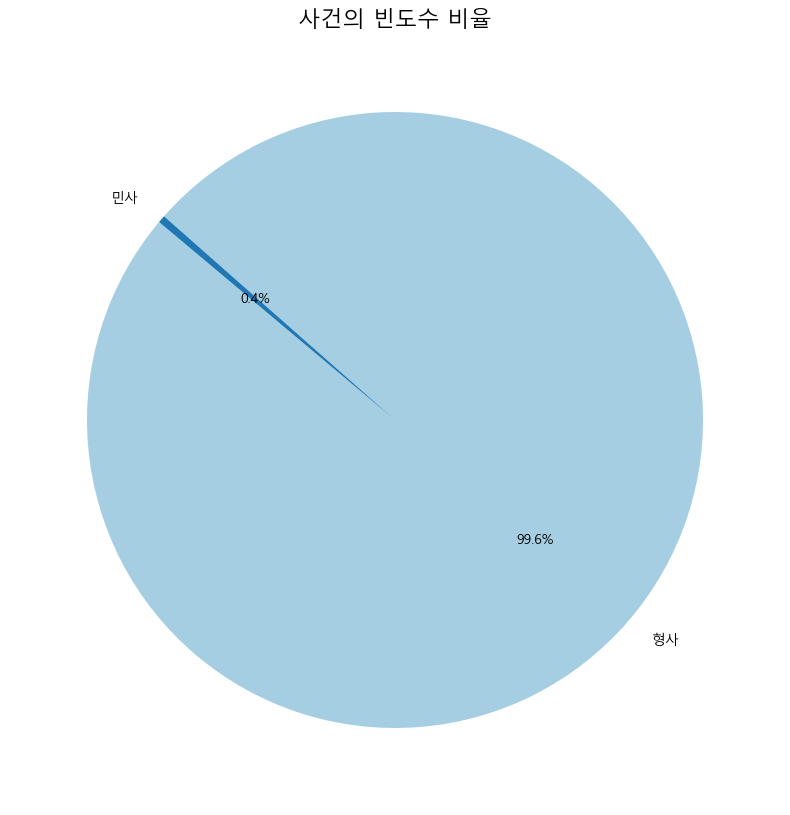

In [39]:
plt.figure(figsize=(10, 10))
plt.pie(df['사건종류명'].value_counts(), labels=df['사건종류명'].value_counts().index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('사건의 빈도수 비율', fontsize=16)
plt.show()

# 선고

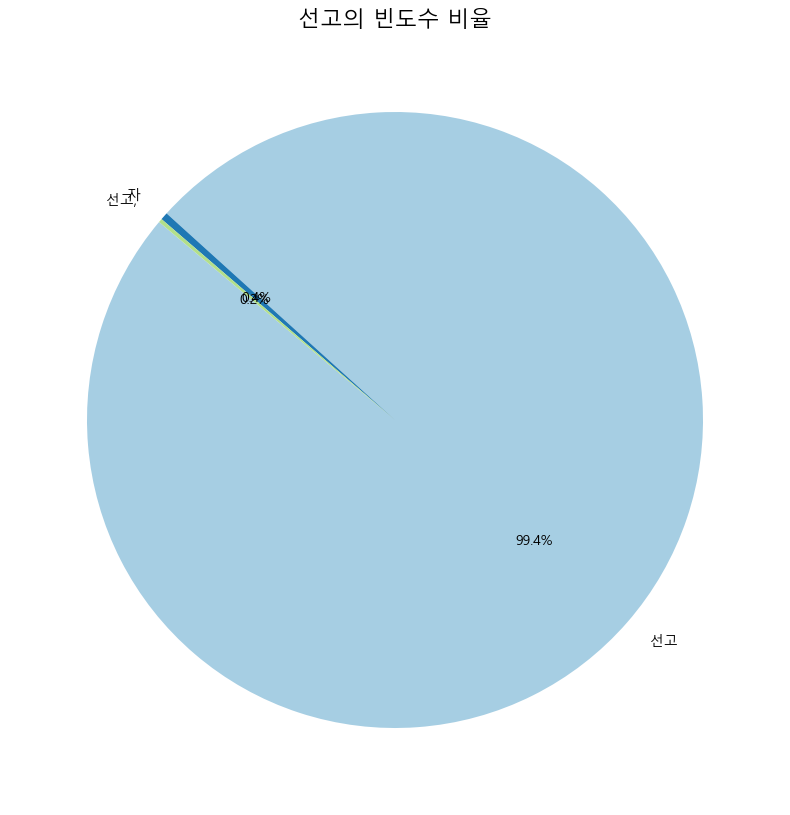

In [40]:
plt.figure(figsize=(10, 10))
plt.pie(df['선고'].value_counts(), labels=df['선고'].value_counts().index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('선고의 빈도수 비율', fontsize=16)
plt.show()

In [41]:
df['선고'].value_counts()

선고
선고     1009
자         4
선고,       2
Name: count, dtype: int64

# 판결유형

In [4]:
df['판결유형'].value_counts()

판결유형
판결                    835
형사부판결 : 확정             25
제1형사부판결 : 확정           16
판결 : 항소                15
제2형사부판결 : 확정           15
판결 : 상고                14
판결 : 확정                11
전원합의체 판결               10
제1형사부판결 : 상고           10
제3형사부판결 : 확정           10
형사부판결 : 상고              8
제3형사부판결 : 상고            6
제5형사부판결 : 확정            5
결정                      4
제2형사부판결 : 상고            4
판결：확정                   3
제4형사부판결 : 상고            3
판결: 상고                  2
판결: 확정                  2
판결：상고                   2
제4형사부판결 : 확정            2
판결 : 상고기각               1
판결 ： 상고기각               1
판결 ： 확정                 1
판결: 항소                  1
판결 : 항소(양형변경)·상고기각      1
판결：상고기각                 1
판결：항소기각, 상소기각           1
판결：항소                   1
전원합의체판결                 1
형사부판결 : 항소              1
 제5형사부판결 : 상고기각         1
제4형사부판결: 일부상고           1
제2형사부판결 : 항소            1
Name: count, dtype: int64

In [10]:
df['판결유형'][df['판결유형'].str.contains('확정', na=False)].value_counts()
# df['판결유형'][df['판결유형']=='*확정'].value_counts()

판결유형
형사부판결 : 확정      25
제1형사부판결 : 확정    16
제2형사부판결 : 확정    15
판결 : 확정         11
제3형사부판결 : 확정    10
제5형사부판결 : 확정     5
판결：확정            3
판결: 확정           2
제4형사부판결 : 확정     2
판결 ： 확정          1
Name: count, dtype: int64

In [11]:
filtered_counts = df['판결유형'][~df['판결유형'].str.contains('확정|상고|항소', na=False)].value_counts()
filtered_counts

판결유형
판결          835
전원합의체 판결     10
결정            4
전원합의체판결       1
Name: count, dtype: int64

In [15]:
def categorize_판결유형(row):
    if '확정' in row:
        return '확정'
    elif '상고' in row:
        return '상고'
    elif '항소' in row:
        return '항소'
    return row

# 판결유형 열에 함수 적용
df['카테고리'] = df['판결유형'].apply(categorize_판결유형)

# 각 카테고리의 빈도수 계산
value_counts = df['카테고리'].value_counts()

# 결과 출력
print(value_counts)

카테고리
판결          835
확정           90
상고           55
항소           20
전원합의체 판결     10
결정            4
전원합의체판결       1
Name: count, dtype: int64


# 참조조문

In [16]:
df['참조조문'].value_counts()

참조조문
형법 제337조<br/>                                                                                              20
형법 제335조<br/>                                                                                              10
형사소송법 제308조<br/>                                                                                            9
형법 제21조<br/>                                                                                                8
형법 제10조<br/>                                                                                                7
                                                                                                           ..
형법 제13조, 제15조, 제17조<br/>                                                                                    1
농지개혁법 제2조 제1항, 제11조, 동법시행령 제33조<br/>                                                                        1
형사소송법 제309조, 제336조, 제360조<br/>                                                                              1
형사소송법

In [6]:
law_names

{'같은법',
 '건축법',
 '검찰집행사무규칙',
 '검찰청법',
 '경범죄처벌법',
 '경비업법',
 '경찰관직무집행법',
 '공직선거및선거부정방지법',
 '공직선거법',
 '교육기본법',
 '교육법',
 '국가보안법',
 '군사법원법',
 '군인사법',
 '군형법',
 '근로기준법',
 '금융실명거래및비밀보장에관한법률',
 '노동관계조정법',
 '노동위원회법',
 '노동쟁의조정법',
 '노동조합및노동관계조정법',
 '농지개혁법',
 '단속법',
 '도로교통법',
 '도로법',
 '동법시행령',
 '문화재보호법',
 '민법',
 '법무사법',
 '법원조직법',
 '변호사법',
 '보호관찰법',
 '부정경쟁방지법',
 '부정수표단속법',
 '사면법',
 '사회보호법',
 '사회보호법시행령',
 '상법',
 '선원법',
 '성폭력범죄의처벌및피해자보호등에관한법률',
 '소년법',
 '수난구호법',
 '시행규칙',
 '신용카드업법',
 '양성평등기본법',
 '어음법',
 '의료법',
 '임대차보호법',
 '자동차관리법',
 '전당포영업법',
 '조세범처벌법',
 '주거환경정비법',
 '중등교육법',
 '즉결심판에관한절차법',
 '직무집행법',
 '집회및시위에관한법률',
 '집회및시위에관한법률시행령',
 '출입국관리법',
 '치료감호법',
 '통신비밀보호법',
 '특례법',
 '특정강력범죄의처벌에관한특례법',
 '특정범죄가중처벌등에관한법률',
 '폭력행위등처벌에관한법률',
 '해사안전법',
 '헌법',
 '헌법재판소법',
 '형법',
 '형사소송규칙',
 '형사소송법'}

In [87]:
import re
def extract_laws(text):
    if isinstance(text, str):  # 텍스트가 문자열인지 확인
    # '법' 또는 '시행령'으로 끝나는 단어를 정규 표현식으로 추출
        laws = re.findall(r'\b(\w+(?:법|시행령|에 관한 법률|규칙))\b', text)
        return set(laws)
    return set()

# 각 참조조문에서 법과 시행령 이름을 찾기
law_names = set()
for reference in df['참조조문']:
    law_names.update(extract_laws(reference))


# 법과 시행령 이름을 붙이는 함수
def add_law_prefix(x):
    if isinstance(x, str):  # 텍스트가 문자열인지 확인
        previous_law = None  # 이전 법 이름 또는 시행령 이름 저장
        new_references = []

        # 참조 조문을 조각으로 나누기
        for part in x.split(','):
            part = part.strip()
            part = re.sub(r'[\[\]［］].*?[\]\］]', '', part)  # 대괄호와 그 안의 내용 제거
            part = re.sub(r'\s*[가-힣]\.\s*', '', part)  # '가.', '나.', '다.'와 같은 패턴 제거
            part = part.strip('<br/>')  # 공백 제거
            part = part.replace('/', ',')  # '/'를 ','로 변경
            part = re.sub(r'\s+', ' ', part).strip()

            # "항"이 포함된 경우 법 이름이 없으면 넘어감
            if re.search(r'\d+항$', part):
                if not any(law in part for law in law_names):
                    continue  # 법 이름이 붙어 있지 않으면 넘어감

            # "조"로 끝나는 경우 법 이름이 없으면 이전 법 이름 붙이기
            elif re.search(r'\d+조$', part):
                if not any(law in part for law in law_names):
                    part = f"{previous_law} {part}"  # 이전 법 이름 붙이기
                for law_name in law_names:
                    if law_name in part:
                        previous_law = law_name  # 법 이름이 있는 경우 업데이트
                        break

            new_references.append(part)

        return ', '.join(new_references)  # 새로운 참조 조문을 합쳐서 반환
    return x  # 문자열이 아닐 경우 그대로 반환

In [93]:
#기존 데이터 프레임 안건드리고 변환

a = df['참조조문'].apply(add_law_prefix)
a=a.fillna('해당 참조조문 없음')
a

0                                형법 제257조 제1항, None 제284조
1       헌법 제12조, 형사소송법 제33조 제1항 제1호, 헌법 제69조, 헌법 제475조...
2       형사소송법 제294조의2 제1항, 형사소송규칙 제134조의10 제1항, 제134조의...
3       헌법 제13조 제1항, 형의 집행 및 수용자의 처우에 관한 법률 제107조, 처우에...
4                                형사소송법 제307조, 형사소송법 제308조
5                       형법 제37조, 형법 제38조, 형사소송법 제438조 제1항
6                                              해당 참조조문 없음
7                               형법 제16조, 형법 제20조, 형법 제21조
8                                              해당 참조조문 없음
9                                              해당 참조조문 없음
10                                             해당 참조조문 없음
11                  약관의 규제에 관한 법률 제5조 , 약관의 규제에 관한 법률 제5조
12      형법 제41조, 제51조 , 형법 제30조, 형법 제41조, 형법 제51조, 형사소...
13      헌법 제12조 제1항, 형법 제1조 제1항 , 도로교통법 제43조, 제152조 제1...
14                                             해당 참조조문 없음
15                                             해당 참조조문 없음
16      도로교통법(2023. 1. 3. 법률 제19158호로 개정되기 전의 것) 제44조 ...
17            

In [89]:
a.fillna('해당 참조조문 없음')

0                                형법 제257조 제1항, None 제284조
1       헌법 제12조, 형사소송법 제33조 제1항 제1호, 헌법 제69조, 헌법 제475조...
2       형사소송법 제294조의2 제1항, 형사소송규칙 제134조의10 제1항, 제134조의...
3       헌법 제13조 제1항, 형의 집행 및 수용자의 처우에 관한 법률 제107조, 처우에...
4                                형사소송법 제307조, 형사소송법 제308조
5                       형법 제37조, 형법 제38조, 형사소송법 제438조 제1항
6                                              해당 참조조문 없음
7                               형법 제16조, 형법 제20조, 형법 제21조
8                                              해당 참조조문 없음
9                                              해당 참조조문 없음
10                                             해당 참조조문 없음
11                  약관의 규제에 관한 법률 제5조 , 약관의 규제에 관한 법률 제5조
12      형법 제41조, 제51조 , 형법 제30조, 형법 제41조, 형법 제51조, 형사소...
13      헌법 제12조 제1항, 형법 제1조 제1항 , 도로교통법 제43조, 제152조 제1...
14                                             해당 참조조문 없음
15                                             해당 참조조문 없음
16      도로교통법(2023. 1. 3. 법률 제19158호로 개정되기 전의 것) 제44조 ...
17            

In [114]:
# Pandas 설정 변경
pd.set_option('display.max_rows', None)  # 모든 행 출력
pd.set_option('display.max_columns', None)  # 모든 열 출력

In [12]:
df['참조조문'][df['참조조문'].str.contains('같은법',na=False)].index

Index([945], dtype='int64')

In [61]:
# 법 이름을 붙이는 함수
def add_law_prefix(x):
    if isinstance(x, str):  # 텍스트가 문자열인지 확인
        previous_law = None  # 이전 법 이름 저장
        new_references = []

        # 참조 조문을 조각으로 나누기
        for part in x.split(','):
            part = part.strip()  # 공백 제거
            if previous_law and not any(law in part for law in law_names):
                # 법 이름이 없는 경우, 이전 법 이름을 붙이기
                part = f"{previous_law} {part}"
            new_references.append(part)

            # 법 이름을 확인하여 업데이트
            for law_name in law_names:
                if law_name in part:
                    previous_law = law_name  # 이전 법 이름 업데이트

        return ', '.join(new_references)  # 새로운 참조 조문을 합쳐서 반환
    return x  # 문자열이 아닐 경우 그대로 반환

# 참조판례

In [105]:
df['참조판례']=df['참조판례'].fillna('참조판례 없음')

In [115]:
print(df['참조판례'])

0       대법원 2002. 6. 14. 선고 2002도1341 판결, 대법원 2004. 6....
1       대법원 2009. 5. 28. 선고 2009도579 판결(공2009하, 1060)(...
2                                                 참조판례 없음
3       대법원 2000. 10. 27. 선고 2000도3874 판결(공2000하, 2487...
4                  대법원 2006. 11. 23. 선고 2006도5407 판결<br/>
5       대법원 2011. 10. 27. 선고 2009도9948 판결, 대법원 2012. 9...
6                                                 참조판례 없음
7                                                 참조판례 없음
8                                                 참조판례 없음
9                                                 참조판례 없음
10                                                참조판례 없음
11       [1] 대법원 2017. 10. 26. 선고 2016다239536 판결, 대법원 ...
12       [1] 대법원 1985. 6. 11. 선고 85도926 판결(공1985, 1038...
13       [1] 대법원 1997. 3. 20. 선고 96도1167 전원합의체 판결(공199...
14                                                참조판례 없음
15                                                참조판례 없음
16                                                참조판례 없음
17            

In [122]:
#참조판례 정리

clean_part=[]
for part in df['참조판례']:
    part = part.strip()
    part = re.sub(r'[\[\]［］].*?[\]\］]', '', part)  # 대괄호와 그 안의 내용 제거
    part = re.sub(r'\s*[가-힣]\.\s*', '', part)  # '가.', '나.', '다.'와 같은 패턴 제거
    part = part.strip('<br/>')  # 공백 제거
    part = part.replace('/', ',')  # '/'를 ','로 변경
    part = re.sub(r'\s+', ' ', part).strip()
    clean_part.append(part)

df['참조판례']=clean_part

In [156]:
refered_jud=[]
for clean_part in df['참조판례']:
    parts = re.split(r',\s*(?![^()]*\))', clean_part)
    for sub in parts:
        refered_jud.append(sub)

refered_jud = [item for item in refered_jud if item.strip()]
refered_jud

['대법원 2002. 6. 14. 선고 2002도1341 판결',
 '대법원 2004. 6. 11. 선고 2004도2018 판결(공2004하, 1198)',
 '대법원 2017. 3. 30. 선고 2017도771 판결',
 '대법원 2009. 5. 28. 선고 2009도579 판결(공2009하, 1060)(변경)',
 '대법원 2011. 9. 29. 선고 2011도10441 판결(변경)',
 '대법원 2011. 11. 10. 선고 2011도12108 판결(변경)',
 '대법원 2012. 6. 28. 선고 2012도5420 판결(변경)',
 '대법원 2016. 6. 9. 선고 2016도4479 판결(변경)',
 '대법원 2017. 1. 12. 선고 2016도19006 판결(변경)',
 '참조판례 없음',
 '대법원 2000. 10. 27. 선고 2000도3874 판결(공2000하, 2487)',
 '대법원 2006. 11. 23. 선고 2006도5407 판결',
 '대법원 2011. 10. 27. 선고 2009도9948 판결',
 '대법원 2012. 9. 27. 선고 2012도9295 판결(공2012하, 1799)',
 '대법원 2019. 6. 20. 선고 2018도20698 전원합의체 판결(공2019하, 1485)',
 '참조판례 없음',
 '참조판례 없음',
 '참조판례 없음',
 '참조판례 없음',
 '참조판례 없음',
 '대법원 2017. 10. 26. 선고 2016다239536 판결',
 '대법원 2022. 3. 17. 선고 2021다284462 판결(공2022상, 712)',
 '대법원 1985. 6. 11. 선고 85도926 판결(공1985, 1038)',
 '대법원 1999. 6. 11. 선고 99도763 판결(공1999하, 1454)',
 '대법원 2003. 6. 13. 선고 2003도924 판결(공2003하, 1566)',
 '대법원 2016. 2. 19. 선고 2015도12980 전원합의체 판결(공2016상, 523)',
 '대법원 1997.

In [157]:
refjud=pd.DataFrame(data=refered_jud)
print(refjud.value_counts())
refjud.describe()

0                                                                                      
참조판례 없음                                                                                    555
대법원 2000. 7. 4. 선고 99도4341 판결(공2000하, 1851)                                                  6
대법원 1994. 3. 22. 선고 93도3612 판결(공1994상, 1373)                                                 4
대법원 1994. 3. 22. 선고 93도2080 전원합의체 판결(공1994상, 1368)                                           4
대법원 2003. 1. 24. 선고 2002도6103 판결(공2003상, 758)                                                4
대법원 2004. 4. 27. 선고 2004도482 판결(공2004상, 946)                                                 4
대법원 2004. 6. 24. 선고 2002도995 판결(공2004하, 1255)                                                4
대법원 2004. 6. 25. 선고 2004도2221 판결(공2004하, 1290)                                               4
대법원 1982.7.13. 선고 82도1352 판결                                                                 3
대법원 1992. 12. 22. 선고 92도2540 판결(공1993상, 657)             

0
count      2050
unique     1303
top     참조판례 없음
freq        555

In [158]:
refjud_fre = refjud.value_counts().reset_index()
refjud_fre.columns=['참조판례','빈도수']
top10refjud=refjud_fre.head(10)
filterd_refjud=refjud_fre[refjud_fre['참조판례']!='참조판례 없음']
top10filterd_refjud=filterd_refjud.head(10)

In [159]:
top10filterd_refjud

참조판례  빈도수
1         대법원 2000. 7. 4. 선고 99도4341 판결(공2000하, 1851)    6
2        대법원 1994. 3. 22. 선고 93도3612 판결(공1994상, 1373)    4
3   대법원 1994. 3. 22. 선고 93도2080 전원합의체 판결(공1994상, 1...    4
4       대법원 2003. 1. 24. 선고 2002도6103 판결(공2003상, 758)    4
5        대법원 2004. 4. 27. 선고 2004도482 판결(공2004상, 946)    4
6       대법원 2004. 6. 24. 선고 2002도995 판결(공2004하, 1255)    4
7      대법원 2004. 6. 25. 선고 2004도2221 판결(공2004하, 1290)    4
8                        대법원 1982.7.13. 선고 82도1352 판결    3
9        대법원 1992. 12. 22. 선고 92도2540 판결(공1993상, 657)    3
10          대법원 1988. 2. 9. 선고 87도2564 판결(공1988, 548)    3

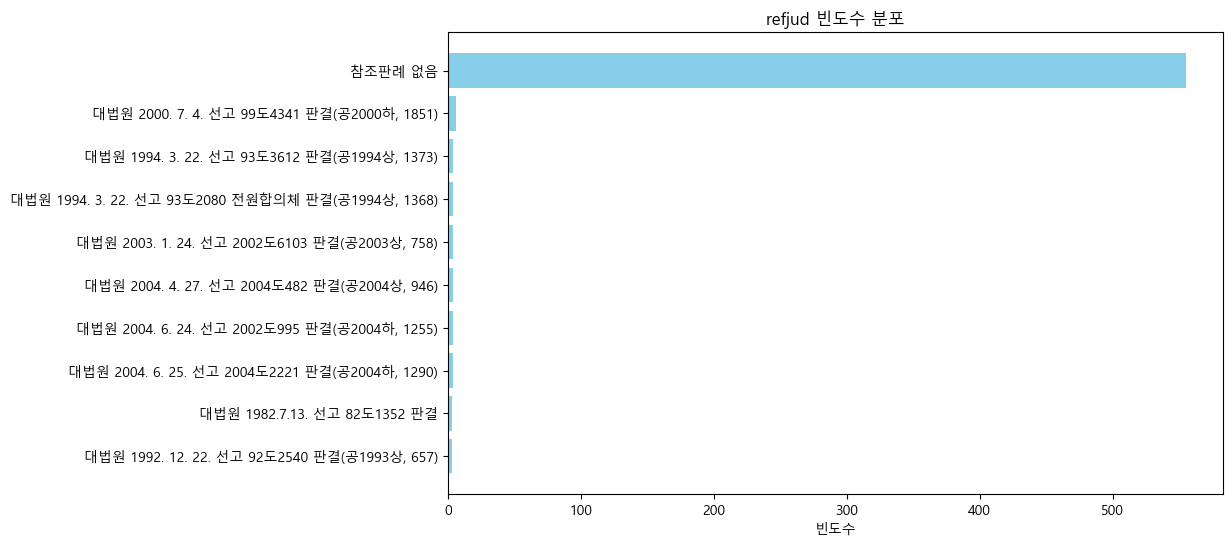

In [160]:
import matplotlib.pyplot as plt

# top10 빈도수 시각화
plt.figure(figsize=(10, 6))
plt.barh(top10refjud['참조판례'], top10refjud['빈도수'], color='skyblue')
plt.xlabel('빈도수')
plt.title('refjud 빈도수 분포')
plt.gca().invert_yaxis()  # y축 반전
plt.show()

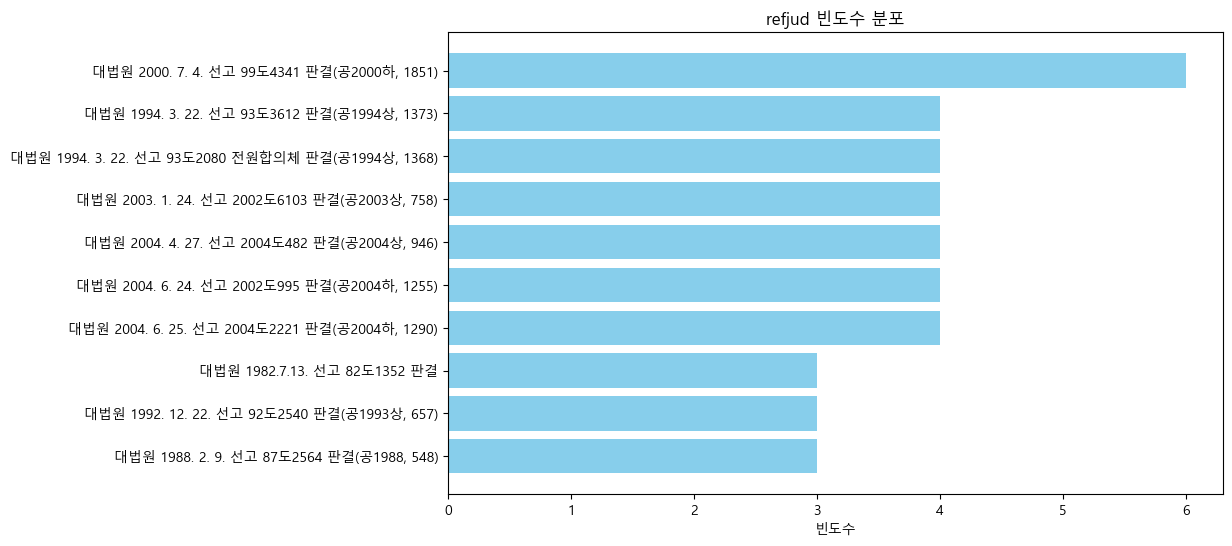

In [161]:
# top10 빈도수(참조판례 없음 제외) 시각화
plt.figure(figsize=(10, 6))
plt.barh(top10filterd_refjud['참조판례'], top10filterd_refjud['빈도수'], color='skyblue')
plt.xlabel('빈도수')
plt.title('refjud 빈도수 분포')
plt.gca().invert_yaxis()  # y축 반전
plt.show()

# 판례내용